<a href="https://colab.research.google.com/github/khykelly-cloud/mul/blob/main/CPLEX_ORTOOLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install cplex
!pip install docplex
!pip install ortools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.30.251-py3-none-any.whl size=685954 sha256=ad3b9166c6cf5ce97fe26d7ee9a6ed69337eab235be143251be48a34d77b8cb1
  Stored in directory: /root/.cache/pip/wheels/c1/d9/5c/1d919b1e441ebbaff244513a13d09c3c0378401601d4184bb0
Successfully built docplex


Opened DCs: [1, 2, 3]

DC 1 – Truck loads: [np.int64(75), np.int64(107), 0, 0, 0]
✔ Truck 0 OK (load 75)
✔ Truck 1 OK (load 107)
✔ Truck 2 OK (load 0)
✔ Truck 3 OK (load 0)
✔ Truck 4 OK (load 0)


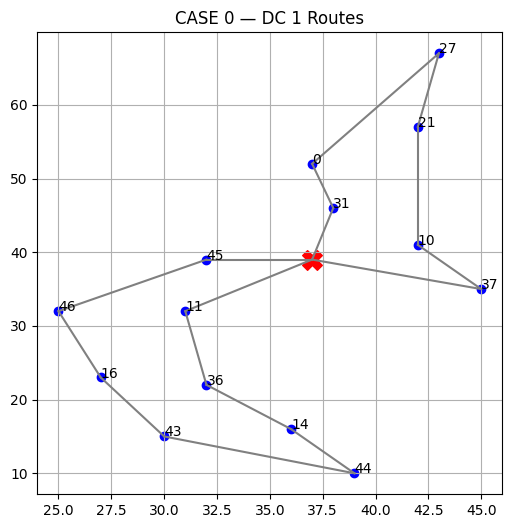


DC 2 – Truck loads: [0, np.int64(148), 0, np.int64(160), np.int64(92)]
✔ Truck 0 OK (load 0)
✔ Truck 1 OK (load 148)
✔ Truck 2 OK (load 0)
✔ Truck 3 OK (load 160)
✔ Truck 4 OK (load 92)


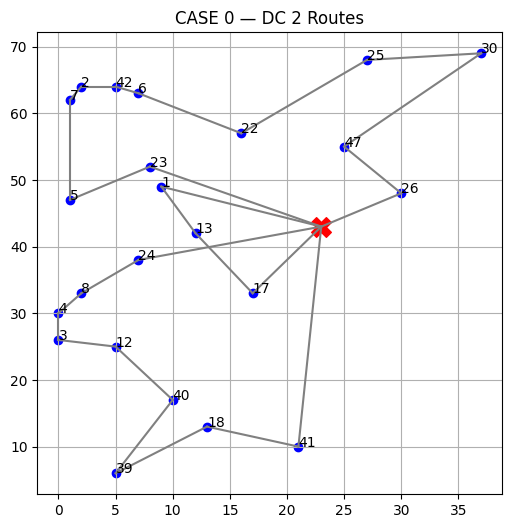


DC 3 – Truck loads: [0, 0, 0, np.int64(80), np.int64(115)]
✔ Truck 0 OK (load 0)
✔ Truck 1 OK (load 0)
✔ Truck 2 OK (load 0)
✔ Truck 3 OK (load 80)
✔ Truck 4 OK (load 115)


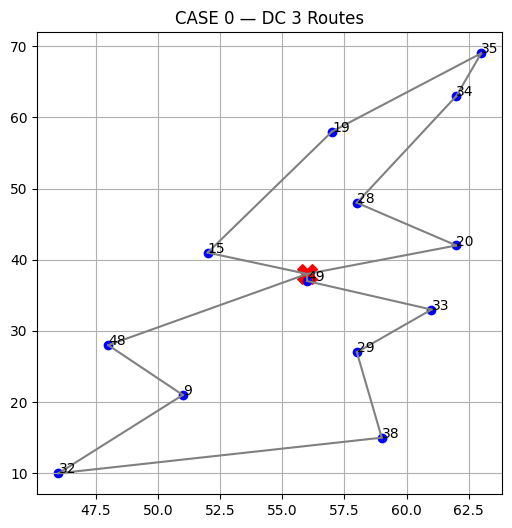


=== CASE 0 최종 결과 ===
개설된 DC: [1, 2, 3]
개설비용: 120
VRP 총 이동거리: 546
👉 총 비용: 666


In [16]:
# =========================================================
# CASE 0 — Baseline (No Extra Constraints)
# CPLEX + OR-Tools VRP(GLS/LNS) + Euclidean + Capacity-Safe
# =========================================================

!pip install cplex docplex ortools --quiet

from docplex.mp.model import Model
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Load Data
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index": "Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index": "DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

OPEN_COST = dc["COST"].iloc[0]
TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])   # = 160
DC_DEMAND_LIMIT = 400   # ⭐ DC 하나가 과도하게 커지지 않도록 컷팅(트럭 3대 분량)

# ---------------------------------------------------------
# Euclidean Distance
# ---------------------------------------------------------
def euclid(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)


# ---------------------------------------------------------
# CPLEX MILP — Case 0 (No extra constraints)
# + DC demand upper bound(400)
# ---------------------------------------------------------
def solve_case0_milp():
    C, D = len(customer), len(dc)
    mdl = Model("Case0")

    # variables
    y = mdl.binary_var_list(D, name="OpenDC")
    x = {(i, j): mdl.binary_var(name=f"x_{i}_{j}") for i in range(C) for j in range(D)}

    # distance matrix
    dist = np.zeros((C, D))
    for i, c in customer.iterrows():
        for j, d in dc.iterrows():
            dist[i][j] = euclid((c["X"], c["Y"]), (d["X"], d["Y"]))

    # objective
    mdl.minimize(
        mdl.sum(OPEN_COST * y[j] for j in range(D)) +
        mdl.sum(dist[i][j] * x[i, j] for i in range(C) for j in range(D))
    )

    # constraints
    for i in range(C):
        mdl.add(mdl.sum(x[i, j] for j in range(D)) == 1)

    for i in range(C):
        for j in range(D):
            mdl.add(x[i, j] <= y[j])

    # ⭐ DC demand limit (safe for VRP)
    for j in range(D):
        mdl.add(
            mdl.sum(customer.iloc[i]["DEMAND"] * x[i, j] for i in range(C))
            <= DC_DEMAND_LIMIT * y[j]
        )

    sol = mdl.solve(log_output=False)
    if sol is None:
        print("❌ MILP infeasible")
        return None, None

    opened = [j for j in range(D) if y[j].solution_value > 0.5]

    assignment = {}
    for i in range(C):
        for j in range(D):
            if x[i, j].solution_value > 0.5:
                assignment[i] = j

    return opened, assignment


# ---------------------------------------------------------
# VRP Solver (GLS/LNS)
# ---------------------------------------------------------
def solve_vrp(dist_matrix, demands, capacity, num_vehicles=5):

    manager = pywrapcp.RoutingIndexManager(len(dist_matrix), num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_cb(from_idx, to_idx):
        return int(dist_matrix[manager.IndexToNode(from_idx)][manager.IndexToNode(to_idx)])

    cb = routing.RegisterTransitCallback(distance_cb)
    routing.SetArcCostEvaluatorOfAllVehicles(cb)

    # demand callback
    def demand_cb(from_idx):
        return demands[manager.IndexToNode(from_idx)]

    dcb = routing.RegisterUnaryTransitCallback(demand_cb)

    routing.AddDimensionWithVehicleCapacity(
        dcb, 0, [capacity] * num_vehicles, True, "Capacity"
    )

    # GLS (metaheuristics)
    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    params.time_limit.seconds = 3

    sol = routing.SolveWithParameters(params)
    if sol is None:
        return None, None, None

    total_distance = 0
    routes = []
    truck_loads = [0] * num_vehicles

    # extract routes
    for v in range(num_vehicles):
        idx = routing.Start(v)
        route = [manager.IndexToNode(idx)]

        while not routing.IsEnd(idx):
            prev = idx
            idx = sol.Value(routing.NextVar(idx))

            node = manager.IndexToNode(idx)
            total_distance += routing.GetArcCostForVehicle(prev, idx, v)

            route.append(node)

            if node != 0:  # depot 제외하고 demand 합산
                truck_loads[v] += demands[node]

        if len(route) > 2:
            routes.append(route)

    return total_distance, routes, truck_loads


# ---------------------------------------------------------
# VRP Execution + Visualization
# ---------------------------------------------------------
def run_case0_vrp(opened_dc, assignment):

    total_vrp_cost = 0

    for dc_id in opened_dc:

        cust_list = [i for i in assignment if assignment[i] == dc_id]

        locs = []
        dc_row = dc.iloc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))

        for cid in cust_list:
            c = customer.iloc[cid]
            locs.append((c["X"], c["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]
        demands = [0] + [customer.iloc[c]["DEMAND"] for c in cust_list]

        vrp_cost, routes, loads = solve_vrp(dist_matrix, demands, TRUCK_CAPACITY)
        total_vrp_cost += vrp_cost

        print(f"\nDC {dc_id} – Truck loads: {loads}")
        for v, load in enumerate(loads):
            if load > TRUCK_CAPACITY:
                print(f"❌ Truck {v} OVERLOAD! (load {load})")
            else:
                print(f"✔ Truck {v} OK (load {load})")

        # visualization
        plt.figure(figsize=(6, 6))
        plt.scatter(dc_row["X"], dc_row["Y"], c="red", s=200, marker="X")

        for cid in cust_list:
            x, y = customer.iloc[cid][["X", "Y"]]
            plt.scatter(x, y, c="blue")
            plt.text(x, y, str(cid))

        for r in routes:
            for k in range(len(r) - 1):
                x1, y1 = locs[r[k]]
                x2, y2 = locs[r[k + 1]]
                plt.plot([x1, x2], [y1, y2], "gray")

        plt.title(f"CASE 0 — DC {dc_id} Routes")
        plt.grid()
        plt.show()

    return total_vrp_cost


# ---------------------------------------------------------
# RUN CASE 0
# ---------------------------------------------------------
opened_dc, assignment = solve_case0_milp()
print("Opened DCs:", opened_dc)

vrp_cost = run_case0_vrp(opened_dc, assignment)
open_cost = len(opened_dc) * OPEN_COST
total_cost = open_cost + vrp_cost

print("\n=== CASE 0 최종 결과 ===")
print("개설된 DC:", opened_dc)
print("개설비용:", open_cost)
print("VRP 총 이동거리:", vrp_cost)
print("👉 총 비용:", total_cost)
print("=======================================")



=== CASE 1 λ 자동 탐색 시작 ===

▶ λ = 0.35 탐색 중...

DC 0 — Truck loads: [0, 0, 0, 0, 155]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 0
✔ 트럭 4 OK: 155


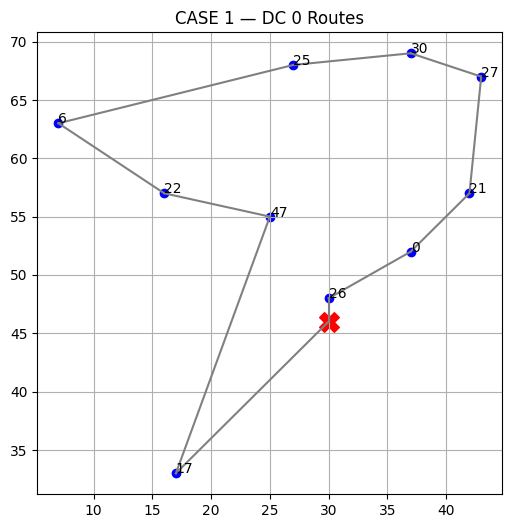


DC 1 — Truck loads: [0, 0, 0, 46, 120]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 46
✔ 트럭 4 OK: 120


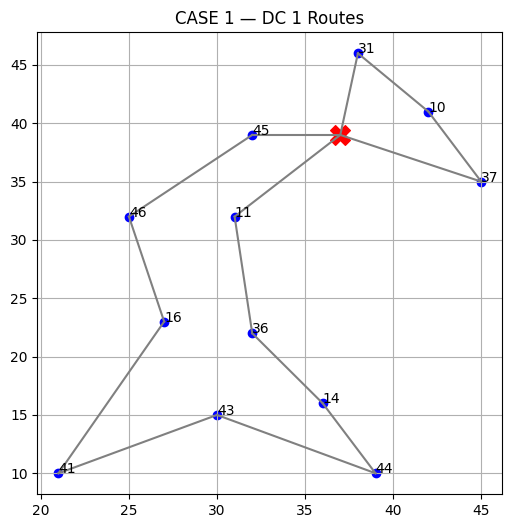


DC 2 — Truck loads: [0, 0, 0, 105, 156]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 105
✔ 트럭 4 OK: 156


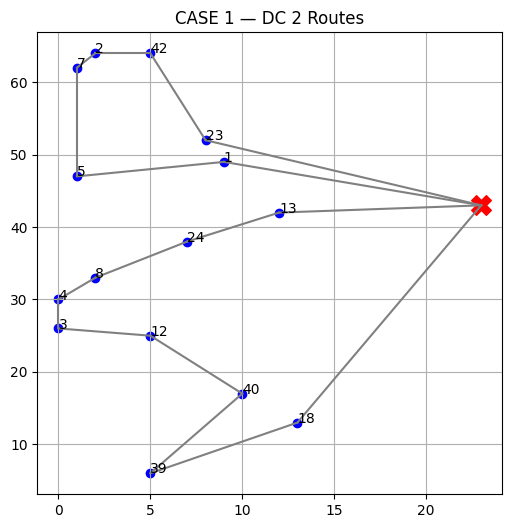


DC 3 — Truck loads: [0, 0, 0, 80, 115]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 80
✔ 트럭 4 OK: 115


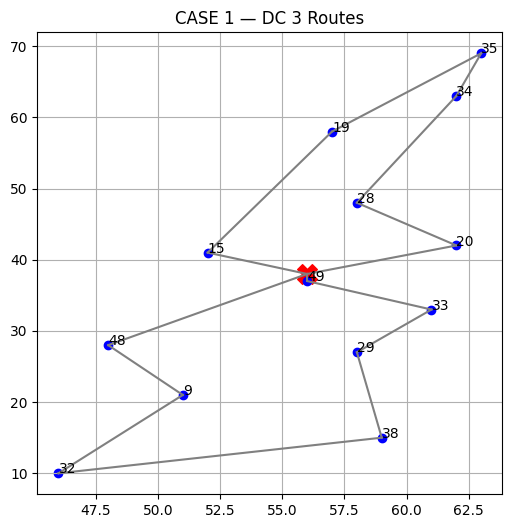

총비용 = 707.0

▶ λ = 0.4 탐색 중...

DC 1 — Truck loads: [0, 0, 0, 115, 159]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 115
✔ 트럭 4 OK: 159


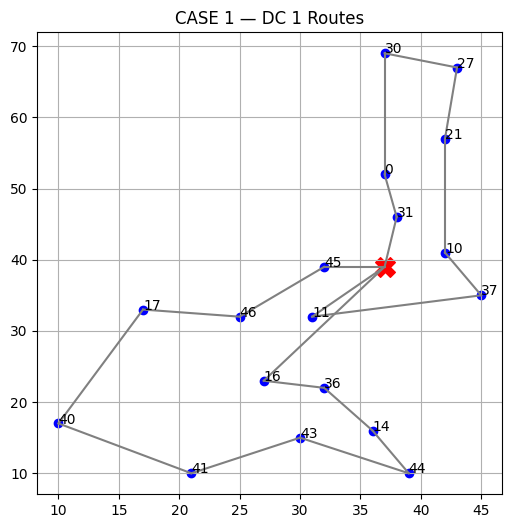


DC 2 — Truck loads: [155, 0, 153, 0, 0]
✔ 트럭 0 OK: 155
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 153
✔ 트럭 3 OK: 0
✔ 트럭 4 OK: 0


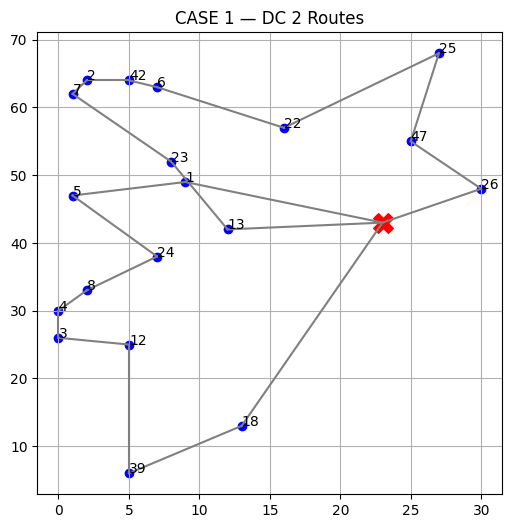


DC 3 — Truck loads: [0, 0, 0, 80, 115]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 80
✔ 트럭 4 OK: 115


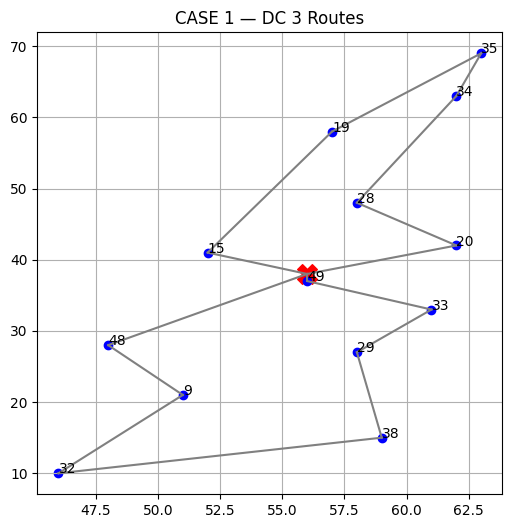

총비용 = 663.0

▶ λ = 0.45 탐색 중...

DC 1 — Truck loads: [0, 0, 0, 86, 147]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 86
✔ 트럭 4 OK: 147


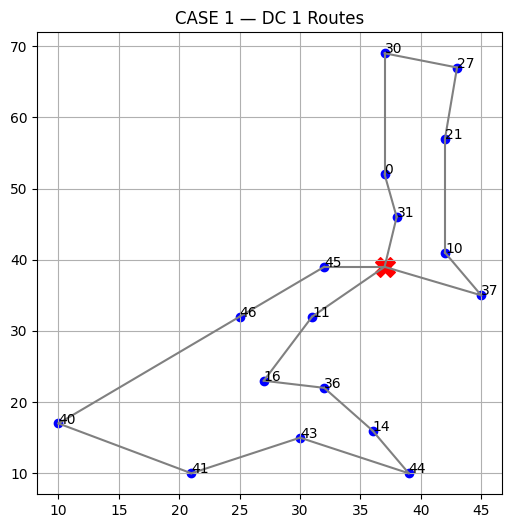


DC 2 — Truck loads: [155, 153, 41, 0, 0]
✔ 트럭 0 OK: 155
✔ 트럭 1 OK: 153
✔ 트럭 2 OK: 41
✔ 트럭 3 OK: 0
✔ 트럭 4 OK: 0


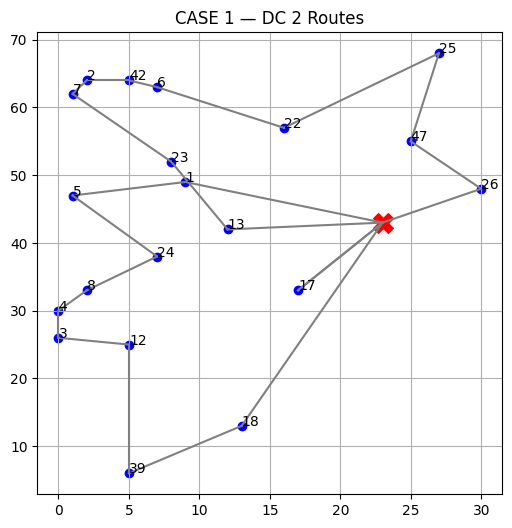


DC 3 — Truck loads: [0, 0, 0, 80, 115]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 80
✔ 트럭 4 OK: 115


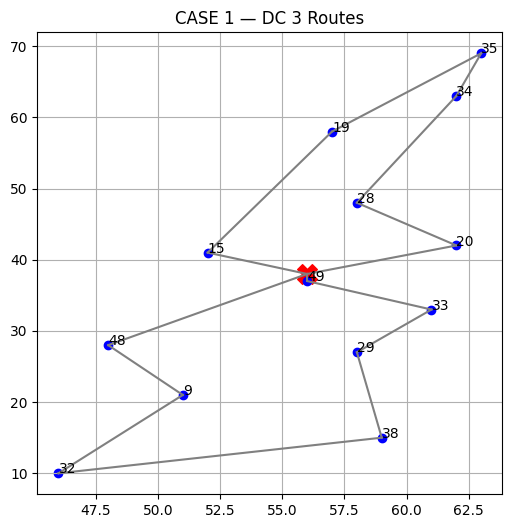

총비용 = 666.0

▶ λ = 0.5 탐색 중...

DC 1 — Truck loads: [75, 0, 0, 0, 120]
✔ 트럭 0 OK: 75
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 0
✔ 트럭 4 OK: 120


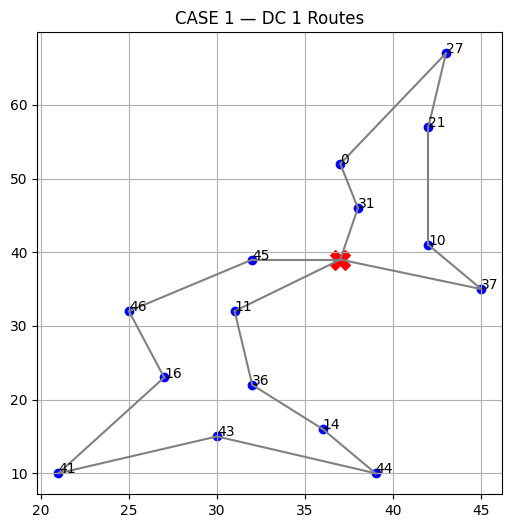


DC 2 — Truck loads: [135, 148, 104, 0, 0]
✔ 트럭 0 OK: 135
✔ 트럭 1 OK: 148
✔ 트럭 2 OK: 104
✔ 트럭 3 OK: 0
✔ 트럭 4 OK: 0


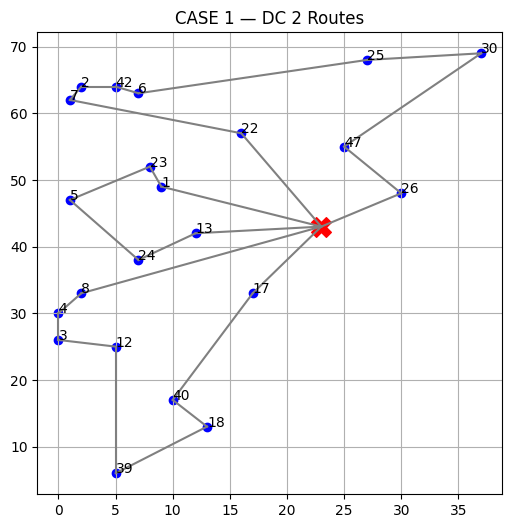


DC 3 — Truck loads: [0, 0, 0, 80, 115]
✔ 트럭 0 OK: 0
✔ 트럭 1 OK: 0
✔ 트럭 2 OK: 0
✔ 트럭 3 OK: 80
✔ 트럭 4 OK: 115


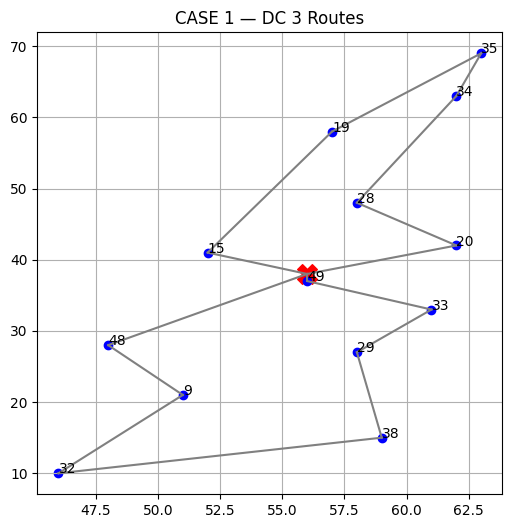

총비용 = 667.0

⭐ 최적 λ = 0.4
⭐ 최소 총비용 = 663.0
⭐ 개설된 DC = [1, 2, 3]


In [20]:
# =========================================================
# CASE 1 — 균형 제약 (Workload Balancing)
# CPLEX MILP + OR-Tools VRP(GLS/LNS) + λ 자동탐색 + Capacity 160 보장
# =========================================================

!pip install cplex docplex ortools --quiet

from docplex.mp.model import Model
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Load Data
# ---------------------------------------------------------
customer = pd.read_csv("/content/Customer.csv").reset_index().rename(columns={"index":"Customer_ID"})
dc = pd.read_csv("/content/DistributionCenter.csv").reset_index().rename(columns={"index":"DC_ID"})
truck = pd.read_csv("/content/Truck.csv")

OPEN_COST = float(dc["COST"].iloc[0])
TRUCK_CAPACITY = int(truck["CAPACITY"].iloc[0])  # 160


# ---------------------------------------------------------
# Euclidean distance
# ---------------------------------------------------------
def euclid(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)



# ---------------------------------------------------------
# CPLEX MILP — 균형 제약 포함
# ---------------------------------------------------------
def solve_case1_milp(lambda_ratio):

    C, D = len(customer), len(dc)
    total_demand = customer["DEMAND"].sum()
    max_demand_per_dc = lambda_ratio * total_demand

    mdl = Model("Case1_Balancing")

    y = mdl.binary_var_list(D, name="OpenDC")
    x = {(i,j): mdl.binary_var(name=f"x_{i}_{j}") for i in range(C) for j in range(D)}

    # distance matrix
    dist = np.zeros((C,D))
    for i, crow in customer.iterrows():
        for j, drow in dc.iterrows():
            dist[i][j] = euclid((crow["X"], crow["Y"]), (drow["X"], drow["Y"]))

    # objective
    mdl.minimize(
        mdl.sum(OPEN_COST * y[j] for j in range(D)) +
        mdl.sum(dist[i][j] * x[i,j] for i in range(C) for j in range(D))
    )

    # base constraints
    for i in range(C):
        mdl.add(mdl.sum(x[i,j] for j in range(D)) == 1)

    for i in range(C):
        for j in range(D):
            mdl.add(x[i,j] <= y[j])

    # ⭐ 균형 제약
    for j in range(D):
        mdl.add(
            mdl.sum(customer.iloc[i]["DEMAND"] * x[i,j] for i in range(C))
            <= max_demand_per_dc
        )

    sol = mdl.solve(log_output=False)
    if sol is None:
        return None, None

    opened = [j for j in range(D) if y[j].solution_value > 0.5]

    assignment = {}
    for i in range(C):
        for j in range(D):
            if x[i,j].solution_value > 0.5:
                assignment[i] = j

    return opened, assignment



# ---------------------------------------------------------
# VRP (GLS/LNS) — Capacity 160 보장 버전
# ---------------------------------------------------------
def solve_vrp(dist_matrix, demands, capacity, num_vehicles=5):

    manager = pywrapcp.RoutingIndexManager(len(dist_matrix), num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    # distance callback
    def distance_cb(from_idx, to_idx):
        f = manager.IndexToNode(from_idx)
        t = manager.IndexToNode(to_idx)
        return int(dist_matrix[f][t])

    dist_cb = routing.RegisterTransitCallback(distance_cb)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb)

    # demand callback (node index 기반)
    def demand_cb(from_idx):
        node = manager.IndexToNode(from_idx)
        return demands[node]

    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_cb)

    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx, 0, [capacity] * num_vehicles, True, "Capacity"
    )

    # GLS/LNS
    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    params.time_limit.seconds = 3

    sol = routing.SolveWithParameters(params)
    if sol is None:
        return None, None, None

    total_dist = 0
    routes = []
    loads = [0]*num_vehicles

    for v in range(num_vehicles):
        idx = routing.Start(v)
        route = [manager.IndexToNode(idx)]

        while not routing.IsEnd(idx):
            prev = idx
            idx = sol.Value(routing.NextVar(idx))
            node = manager.IndexToNode(idx)

            total_dist += routing.GetArcCostForVehicle(prev, idx, v)
            route.append(node)

            if node != 0:
                loads[v] += demands[node]

        if len(route) > 2:
            routes.append(route)

    return total_dist, routes, loads



# ---------------------------------------------------------
# VRP 실행 + 시각화
# ---------------------------------------------------------
def run_case1_vrp(opened_dc, assignment):

    total_vrp_cost = 0

    for dc_id in opened_dc:

        cust_list = [i for i in assignment if assignment[i] == dc_id]

        locs = []
        dc_row = dc.iloc[dc_id]
        locs.append((dc_row["X"], dc_row["Y"]))

        for cid in cust_list:
            row = customer.iloc[cid]
            locs.append((row["X"], row["Y"]))

        n = len(locs)
        dist_matrix = [[euclid(locs[i], locs[j]) for j in range(n)] for i in range(n)]

        # ⭐ 정확한 demand 매핑 (node index 기반)
        demands = [0]
        for cid in cust_list:
            dem = int(customer.loc[customer["Customer_ID"] == cid, "DEMAND"].values[0])
            demands.append(dem)

        vrp_cost, routes, loads = solve_vrp(dist_matrix, demands, TRUCK_CAPACITY)
        total_vrp_cost += vrp_cost

        print(f"\nDC {dc_id} — Truck loads:", loads)
        for i, load in enumerate(loads):
            if load > TRUCK_CAPACITY:
                print(f"🚨 트럭 {i} 적재 초과: {load}")
            else:
                print(f"✔ 트럭 {i} OK: {load}")

        # plot
        plt.figure(figsize=(6,6))
        plt.scatter(dc_row["X"], dc_row["Y"], c="red", s=200, marker="X")

        for cid in cust_list:
            x,y = customer.iloc[cid][["X","Y"]]
            plt.scatter(x, y, c="blue")
            plt.text(x, y, str(cid))

        for r in routes:
            for k in range(len(r)-1):
                x1,y1 = locs[r[k]]
                x2,y2 = locs[r[k+1]]
                plt.plot([x1,x2],[y1,y2],"gray")

        plt.title(f"CASE 1 — DC {dc_id} Routes")
        plt.grid()
        plt.show()

    return total_vrp_cost



# ---------------------------------------------------------
# λ 자동 탐색
# ---------------------------------------------------------
lambda_candidates = [0.35, 0.40, 0.45, 0.50]

results = []

print("\n=== CASE 1 λ 자동 탐색 시작 ===")

for lam in lambda_candidates:

    print(f"\n▶ λ = {lam} 탐색 중...")

    opened, assignment = solve_case1_milp(lam)
    if opened is None:
        print(" - MILP infeasible")
        continue

    vrp_cost = run_case1_vrp(opened, assignment)
    total = vrp_cost + len(opened)*OPEN_COST

    print(f"총비용 = {total}")

    results.append([lam, total, opened])

# 최적 λ 찾기
best = sorted(results, key=lambda x: x[1])[0]

best_lambda = best[0]
best_cost   = best[1]
best_opened = best[2]

print("\n============================")
print("⭐ 최적 λ =", best_lambda)
print("⭐ 최소 총비용 =", best_cost)
print("⭐ 개설된 DC =", best_opened)
print("============================")
